<a href="https://colab.research.google.com/github/mniab/PairsTradingStrategy/blob/main/Pair_Trading_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 15.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=eb7c6aa04ce9d037e6fc2400b8cae788cb7cc9cab3940b9e21bfa756e2f42d80
  Stored in directory: /root/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
# import the libraries
 
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint   # use this library to find this out the p_value
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from functools import cmp_to_key
import datetime
import yfinance as yf


In [ ]:
# predefined functions in this cell ,  no need to chagne them
 
def downloadStockData(tickers,start,end):
    """
        This function downloads the Close price of the stock and creates a dataframe from it
        Params:
            tickers : a list of ticker of various stocks
            start   : it is the start date of the data to be downloaded. It is a datetime in datetime format.
            end     : it is the end date of the data to be downloaded. It is a datetime in datetime format.
 
        Return:
            A dataframe with all the close for of each stock on each open market day
    """
    ticker_data = yf.download(tickers, start, end)['Close']
    return ticker_data
 
def zscore(series):
    newSeries = series.copy()
    for i in range(len(newSeries)):
        x = (newSeries[i] - newSeries[:i+1].mean()) / np.std(newSeries[:i+1])
        series[i]= x
    return series
def plot_ratios(ratios):
    """
        This function just plots the ratios plot 
        Params:
            ratio : a list of the the ration of two stock price 
    """
    ratios.plot()
    plt.axhline(ratios.mean(),color="yellow")
    plt.show()

In [ ]:
def findCointegrationValue(data,p_value_threshold=0.05):
    """
        This function find out the pairs of stock with p value less than a constant
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            p values of all the pairs , the list of all the pairs with p value less than the threshold 
    """
    n = data.shape[1]
    p_values_matrix = np.ones((n,n));
    keys = data.keys();
    pairs = []
    for i in range(n):
      for j in range(i+1,n):
        S1 = data[keys[i]]
        S2 = data[keys[j]]
        result = coint(S1,S2)
        score = result[0]
        pvalue = result[1]
        p_values_matrix[i,j]=pvalue
        if(pvalue < p_value_threshold):
          pairs.append(((i,j),pvalue))
        
    return p_values_matrix,pairs

In [ ]:
def compare(x,y):
  return x[1]-y[1]

In [ ]:
def getBestKCointergratedStocks(data,k=10,p_value_threshold=0.05):
    """
        This functions find out the k pairs with the least p value and all of them should be less than the threshold  
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            k                  : the number of pairs to be found out
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            the p value for all the pairs of stocks , the list k pairs with the least p value and their p values . If k such pairs doesn't exists return how many of them occur 
    """
    p_values_matrix, pairs = findCointegrationValue(data)
    tem=sorted(pairs,key=cmp_to_key(compare))
    if len(tem) < k:
      return p_values_matrix,tem
    return p_values_matrix,tem[0:k]
   

In [ ]:
def normalize(series):
  return series-series.min()/(series.max()-series.min())

In [ ]:
def distanceBetweenStocks(data1,data2,window_size):
    """
        This function takes list of two stocks and find the distance between the stocks 
        Params:
            data1: list of stock price of stock1
            data2: list of stock price of stock2
            window_size : the window size
        Returns:
            the distance between the lists

        Note:
            In this function do try to normalise the stock price and try out some variations in it.
    """
    data1 = normalize(data1)
    data2 = normalize(data2)
    distance=0 
    for i in range(len(data1)):
      distance += (data1[i] - data2[i])**2
    
    return distance


In [ ]:
def getBestKLessDistanceStocks(data,k=10):
    """
        This functions find out the k pairs with the least distance between them  
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            k                  : the number of pairs to be found out
            
        Returns:
            the distance between all the stock pairs, the list of k pairs with the least distance between them
    """
    n = data.shape[1]
    keys=data.keys();
    pairs=[]
    _distance=np.ones((n,n))
    for i in range(n):
      for j in range (i+1,n):
        d1=data[keys[i]]
        d2=data[keys[j]]
        ans=distanceBetweenStocks(d1,d2,100)
        _distance[i][j]=ans
        pairs.append((i,j))
    
    pairs.sort(key=cmp_to_key(compare))
    if(len(pairs)<k):
      return _distance,pairs
    return _distance,pairs[0:k]

In [ ]:
tickers = ['HD', 'DIS','MSFT', 'BA', 'MMM', 'PFE', 'NKE', 'JNJ', 'MCD', 'INTC', 'XOM', 'GS', 'JPM', 'AXP', 'V', 'IBM', 'UNH', 'PG', 'GE', 'KO', 'CSCO', 'CVX', 'CAT', 'MRK', 'WMT', 'VZ', 'RTX', 'TRV', 'AAPL', 'ADBE', 'EBAY', 'QCOM', 'HPQ', 'JNPR', 'AMD']
start = datetime.datetime(2011,1,1)
end = datetime.datetime(2017,1,1)
data = downloadStockData(tickers,start,end)

[*********************100%***********************]  35 of 35 completed


In [ ]:
data.head(5)

,AAPL,ADBE,AMD,AXP,BA,CAT,CSCO,CVX,DIS,EBAY,GE,GS,HD,HPQ,IBM,INTC,JNJ,JNPR,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,QCOM,RTX,TRV,UNH,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-03,11.770357,31.290001,8.47,43.400002,66.400002,94.150002,20.490000,91.940002,37.820000,12.070707,17.576923,173.050003,35.310001,19.409628,147.479996,20.850000,62.820000,37.240002,43.580002,32.610001,76.599998,86.790001,34.389313,27.98,21.522499,16.774195,64.769997,50.180000,49.710510,55.820000,37.130001,17.629999,36.430000,54.560001,74.550003
2011-01-04,11.831786,31.510000,8.77,43.950001,66.940002,93.709999,20.520000,91.599998,38.990002,11.982323,17.894232,173.080002,34.669998,19.813807,147.639999,21.150000,63.349998,37.160000,44.160000,31.934999,74.309998,86.669998,34.685116,28.09,20.992500,17.068312,64.949997,50.970001,49.792320,55.570000,37.470001,17.650000,37.160000,54.770000,74.900002
2011-01-05,11.928571,32.220001,8.91,45.040001,67.480003,94.519997,20.770000,91.440002,39.959999,12.091751,17.923077,174.000000,34.560001,20.072660,147.050003,20.940001,63.310001,37.880001,44.700001,31.745001,74.660004,86.669998,34.885494,28.00,21.129999,17.182163,64.800003,52.029999,49.861549,55.240002,37.590000,18.022499,37.669998,54.410000,74.699997
2011-01-06,11.918929,32.270000,8.69,44.730000,68.800003,93.540001,20.950001,90.690002,39.650002,11.961279,17.846153,172.210007,34.419998,20.381472,148.660004,20.770000,63.209999,38.209999,44.480000,31.514999,74.209999,86.139999,35.362595,28.82,20.940001,17.248577,64.690002,52.669998,49.811203,54.389999,38.369999,18.292500,36.230000,53.959999,75.180000
2011-01-07,12.004286,32.040001,8.83,44.360001,69.379997,93.730003,20.969999,91.190002,39.450001,11.658249,17.721153,170.690002,34.380001,20.476839,147.929993,20.660000,62.599998,37.590000,43.639999,31.459999,74.370003,86.230003,35.639313,28.60,20.882500,17.400379,64.500000,51.730000,49.767151,53.330002,38.450001,18.240000,35.930000,54.080002,75.589996


In [ ]:
p_value_matrix,bestCointegrated = getBestKCointergratedStocks(data)
bestCointegrated

[((6, 29), 0.002128866355935751),
 ((19, 32), 0.00631237685580102),
 ((29, 31), 0.006740618270852377),
 ((6, 31), 0.008528399740011761),
 ((27, 34), 0.009682038801937767),
 ((6, 12), 0.011410367412724205),
 ((14, 24), 0.012435151410666673),
 ((1, 23), 0.013090705373873504),
 ((6, 21), 0.016258595664209084),
 ((19, 25), 0.016729291913997545)]

In [ ]:
keys=data.keys()

The lowest P-value showing the maximum cointegration is plotted below

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


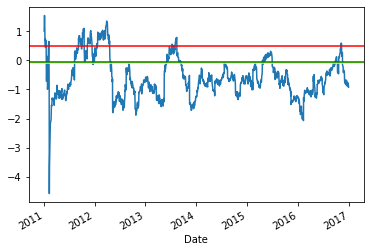

CSCO TRV


In [ ]:
S1=keys[bestCointegrated[0][0][0]]
S2=keys[bestCointegrated[0][0][1]]
ratios = data[S1]/data[S2]
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="yellow")
plt.axhline(0.5, color="red")
plt.axhline(-0.05, color="green")
plt.show()
print(S1,S2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


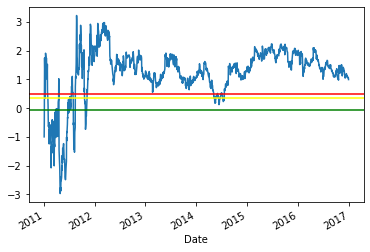

In [ ]:
ratios=data['HD'].copy()/data['TRV'].copy() 
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="yellow")
plt.axhline(0.5, color="red")
plt.axhline(-0.05, color="green")
plt.show()